In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import seaborn as sns
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.externals import joblib
import datetime
import statsmodels
from scipy import stats
from scipy.stats import norm
import pykalman
import sklearn
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
import pickle
%matplotlib inline

In [2]:
def date_parser(string):
    return datetime.datetime.fromtimestamp(int(string))

In [3]:
def divide_square(x,y):
    if y == 0:
        return x
    else:
        return x/(y*y)
    
def reward_difference(pred, actual):
    if actual < 0 and pred < actual:
        return 0.25 * (actual-pred) * (actual - pred)
    elif actual < 0 and pred > actual:
        return 2.25 * (actual-pred) * (actual - pred)
    else:
        return (actual-pred) * (actual - pred)
    
def mape(y_true, y_pred): 
    return np.mean(np.abs(map(divide,y_true - y_pred,y_true))) * 100

def reward_mape(y_true, y_pred):
    return mp.mean(np.sqrt(map(divide_square, map(reward_difference, y_pred , y_true), y_true))) * 100

In [4]:
data = pd.read_csv('../data/coinbaseUSD.csv',names=['time','price','volume'],nrows=80000,parse_dates=['time'],date_parser=date_parser)
data = data[5500:]

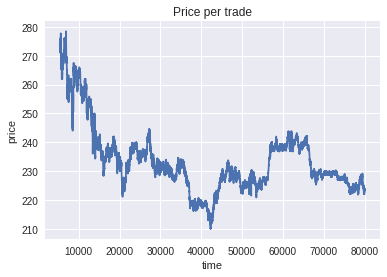

In [5]:
plt.plot(data.price)
plt.xlabel('time')
plt.ylabel('price')
plt.title('Price per trade')
#plt.gcf().autofmt_xdate()
plt.show()

It seems that prices are highly affected by lagged prices over short period. we take lag variables are regressors. we do a grid search on few lags to get the local optimal value.

In [6]:
LAGS = [100,200,300,400,500]
LAG = LAGS[1]
for i in range(1,LAG+1):
    var = 'price' + str(i)
    data[var] = data.price.shift(i)
data['target'] = data.price.shift(-1)    
data = data.dropna()    
data.target = (data.target - data.price)/data.price
target = data.target

First check normality of target variable.

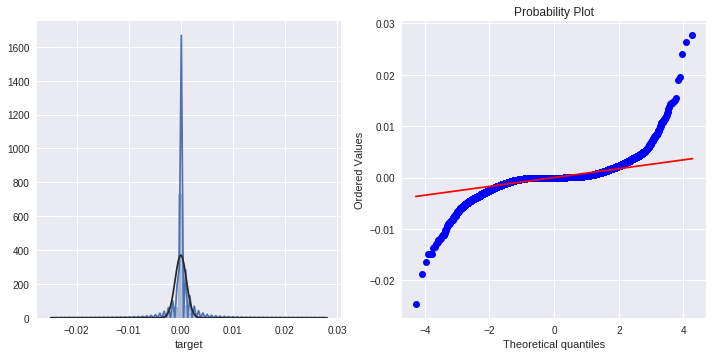

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,12))
plt.subplot(2,2,1)
sns.distplot(data.target,fit=norm)
plt.subplot(2,2,2)
res = stats.probplot(data.target,plot=plt)
plt.show()

In [8]:
print (target.describe())

count    74299.000000
mean        -0.000002
std          0.001076
min         -0.024670
25%         -0.000085
50%          0.000000
75%          0.000088
max          0.027780
Name: target, dtype: float64


In [9]:
train_size = .8
train = data.iloc[:int(data.shape[0]*train_size)].reset_index(drop=True)
test = data.iloc[int(data.shape[0]*train_size):].reset_index(drop=True)
del data

In [10]:
regressors1 = [i for i in train.columns if i == 'price' or (i == 'volume') or ('price' in i and int(i.replace('price','')) <= LAG)]
regressors2 = [i for i in train.columns if i == 'price' or (i == 'volume') or ('price' in i and int(i.replace('price','')) <= LAG/2)]
regressors3 = [i for i in train.columns if i == 'price' or (i == 'volume') or ('price' in i and int(i.replace('price','')) <= LAG/4)]
regressors4 = [i for i in train.columns if i == 'price' or (i == 'volume') or ('price' in i and int(i.replace('price','')) <= LAG/8)]

Reduce dimensionality by picking handful of important variables. we will check the feature importance based on extra trees model

In [11]:
clf = ExtraTreesRegressor(criterion='mse',n_estimators=50,verbose=1)
clf.fit(train[regressors1],train.target)
print (clf.score(train[regressors1],train.target))
print (np.sqrt(mean_squared_error(train.target, clf.predict(train[regressors1]))))

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished


0.976324623588
0.000169809475261


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished


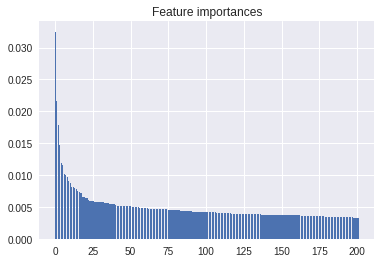

In [12]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(regressors1)), importances[indices])
plt.show()

In [14]:
for f in range(51):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 0 (0.032490)
2. feature 1 (0.021671)
3. feature 2 (0.017916)
4. feature 3 (0.014698)
5. feature 5 (0.011946)
6. feature 4 (0.011616)
7. feature 6 (0.010107)
8. feature 8 (0.010026)
9. feature 7 (0.009741)
10. feature 9 (0.009041)
11. feature 10 (0.008749)
12. feature 11 (0.008149)
13. feature 12 (0.008137)
14. feature 15 (0.007915)
15. feature 13 (0.007792)
16. feature 14 (0.007550)
17. feature 17 (0.007409)
18. feature 16 (0.007236)
19. feature 39 (0.006597)
20. feature 19 (0.006569)
21. feature 23 (0.006384)
22. feature 18 (0.006370)
23. feature 20 (0.006087)
24. feature 44 (0.005901)
25. feature 22 (0.005881)
26. feature 29 (0.005877)
27. feature 28 (0.005833)
28. feature 38 (0.005831)
29. feature 27 (0.005749)
30. feature 31 (0.005748)
31. feature 99 (0.005737)
32. feature 26 (0.005704)
33. feature 60 (0.005704)
34. feature 30 (0.005640)
35. feature 25 (0.005573)
36. feature 32 (0.005548)
37. feature 21 (0.005523)
38. feature 49 (0.005477)
39. feature 37 (0.005454)
40. f

In [15]:
print (np.sqrt(mean_squared_error(test.target, clf.predict(test[regressors1]))))

0.000956024590819


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


we see that first 50 features are good enough to predict the next tick return. also, the extratree r2 score is 97% which indicates the goodness of the model. rmse on test data is .0009. we next see the mse and r2 of bayesian regression model

In [16]:
clf = BayesianRidge(normalize=True,fit_intercept=True)
clf.fit(train[regressors1],train.target)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False)

In [22]:
print (clf.score(train[regressors1],train.target))
print (np.sqrt(mean_squared_error(train.target, clf.predict(train[regressors1]))))
print (np.sqrt(mean_squared_error(test.target, clf.predict(test[regressors1]))))

0.0359085245429
0.00108360897915
0.000926488573981


we see r2 for bayesian model is .03 but less rmse. we use bayesian regression instead of extratrees. we first build best regression model by optimizing the hyperparameters. Also our rmses are around 1/10th of the standard deviation.

In [16]:
def hyperopt_regression(params):
    clf = BayesianRidge(**params)
    clf.fit(train[regressors1],train.target)
    pred = clf.predict(test[regressors1])
    return mean_squared_error(pred, test.target)

space4br = {
    'n_iter': hp.choice('n_iter', [200,300,400,500,600]),
    'tol': hp.choice('tol', [.005,.001,.0005,.0001,.00005,.00001,.000001,.0000001]),
    'fit_intercept': hp.choice('fit_intercept', [True, False]),
    'normalize': hp.choice('normalize', [True, False]),
    'lambda_1': hp.choice('lambda_1', [0,.5,1,2,5,10]),
    'lambda_2': hp.choice('lambda_2', [0,.5,1,2,5,10]),
    'alpha_1': hp.choice('alpha_1', [0,.5,1,2,5,10]),
    'alpha_2': hp.choice('alpha_2', [0,.5,1,2,5,10])                
}

def f(params):
    acc = hyperopt_regression(params)
    return {'loss': acc, 'status': STATUS_OK}

In [17]:
trials = Trials()
best = fmin(f, space4br, algo=tpe.suggest, max_evals=200, trials=trials)
print ('best:')
print (best)

best:
{'alpha_1': 0, 'alpha_2': 0, 'fit_intercept': 0, 'lambda_1': 0, 'lambda_2': 5, 'n_iter': 2, 'normalize': 1, 'tol': 3}


In [20]:
best_params = space_eval(space4br, best)
clf = BayesianRidge(**best_params)
clf.fit(train[regressors1],train.target)
joblib.dump(clf, '../saved_models/regression_model1.pkl')
pred = clf.predict(test[regressors1])
print (np.sqrt(mean_squared_error(pred, test.target)))

0.000925287527629


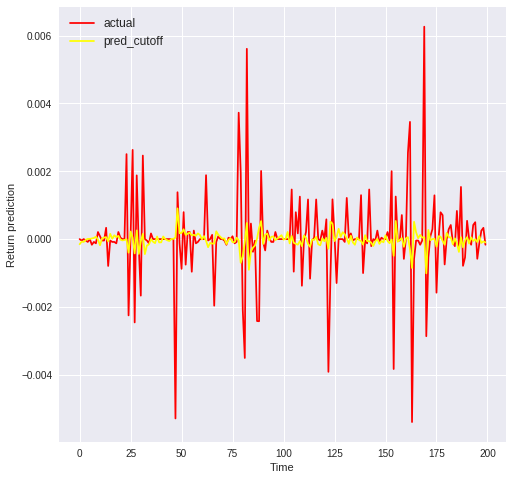

In [21]:
plt.figure(figsize=(10,10))
plt.plot(test.target[:200],color='red',label='actual')
plt.plot(pred[:200],color='yellow',label='prediction')
plt.xlabel("Time")
plt.ylabel('Return prediction')
plt.legend(loc="best", prop=dict(size=12))
plt.show()

Lets formulate a basic trading strategy. When current position is <= 0 and price diff >= buy limit we buy. If current
position is >= 0 and price diff <= sell limit we sell. Else we hold the position. we check the best possible profit using simple buy and sell limit. 

In [23]:
def backtest(pred,actual_price,buy_limit,sell_limit,current_pos=0,cum_profit=0,current_balance=0):
    profit = []
    balance = []
    buy = [0]*len(pred)
    sell = [0]*len(pred)
    for index, i in enumerate(pred):
        if i >= buy_limit and current_pos <= 0:
            current_pos = 1
            buy_price = actual_price[index]
            current_balance -= buy_price
            buy[index] = 1
        if i <= sell_limit and current_pos == 1:
            current_pos = 0
            sell_price = actual_price[index] 
            current_balance += sell_price
            cum_profit = current_balance
            sell[index] = -1
        profit.append(cum_profit)
        balance.append(current_balance)
    return balance, profit, buy, sell

In [24]:
space4st = {
    'buy_limit': hp.choice('buy_limit', [.7,.75,.8,.85,.9]),
    'sell_limit': hp.choice('sell_limit', [.05,.1,.15,.2,.25,.3])
}

def f(params):
    buy_limit = np.percentile(target, params['buy_limit']*100)
    sell_limit = np.percentile(target, params['sell_limit']*100)
    balance, profit, buy, sell = backtest(pred,list(test.price),buy_limit,sell_limit)
    val = max(profit)
    return {'loss': -val, 'status': STATUS_OK}

In [24]:
trials = Trials()
best = fmin(fn=f, space=space4st, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:', best)

best: {'buy_limit': 1, 'sell_limit': 4}


In [26]:
best_params = space_eval(space4st, best)
buy_limit = np.percentile(target, best_params['buy_limit']*100)
sell_limit = np.percentile(target, best_params['sell_limit']*100)
best_params = {'buy_limit':buy_limit, 'sell_limit':sell_limit}
pickle.dump(best_params, open('../saved_models/params_regression1.pkl','wb'))
print ("buy limit is return of " + str(buy_limit*100) + '%')
print ("sell limit is return of " + str(sell_limit*100) + '%')
balance, profit, buy, sell = backtest(pred,list(test.price),buy_limit,sell_limit)

buy limit is return of 0.00879855703665%
sell limit is return of -0.00845505083977%


/home/victor/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


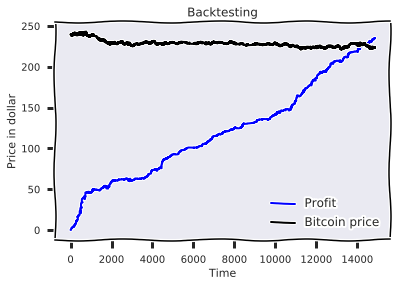

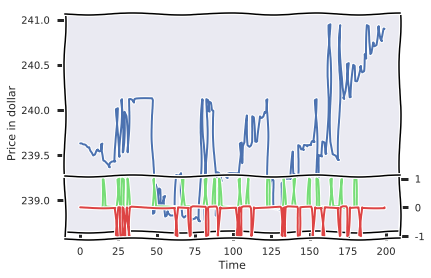

In [27]:
with plt.xkcd():
    plt.title('Backtesting')
    plt.plot(profit, color='blue', label="Profit")
    plt.plot(test.price, color = 'black', label = 'Bitcoin price')
    plt.xlabel("Time")
    plt.ylabel("Price in dollar")
    plt.legend(loc="best", prop=dict(size=12))
    plt.show()
    
with plt.xkcd():
    fig,ax1 = plt.subplots(1,1)
    ax1.plot(test.price[:200])
    plt.xlabel("Time")
    plt.ylabel("Price in dollar")
    ax2 = ax1.twinx()
    ax2.set_position(Bbox([[0.125,0.1],[0.9,0.32]]))
    ax2.plot(buy[:200], color='#77dd77')
    ax2.plot(sell[:200], color='#dd4444')
    plt.show()    

In [31]:
print ("max profit at", test.time.iloc[profit.index(max(profit))], "with profit of USD ", max(profit), "and bitcoin price USD ",test.price.iloc[profit.index(max(profit))]) 
print ("profit at", test.time.iloc[0], "with profit of USD ", profit[0], "and bitcoin price USD ",test.price.iloc[0])
print ("profit at", test.time.iloc[-1], "with profit of USD ", profit[-1], "and bitcoin price USD ",test.price.iloc[-1])

max profit at 2015-02-04 19:51:54 with profit of USD  234.86 and bitcoin price USD  224.11
profit at 2015-02-03 23:13:42 with profit of USD  0 and bitcoin price USD  239.63
profit at 2015-02-04 19:51:59 with profit of USD  234.86 and bitcoin price USD  223.88


Now we replicate the same strategy for extratrees regressor

In [25]:
def hyperopt_extratrees(params):
    clf = ExtraTreesRegressor(**params)
    clf.fit(train[regressors1],train.target)
    pred = clf.predict(test[regressors1])
    return mean_squared_error(pred, test.target)

space4et = {
    'n_estimators': hp.choice('n_estimators', [50,100,200,300,500,800]),
    'max_features': hp.choice('max_features', ["auto","sqrt","log2"]),
    'max_depth': hp.choice('max_depth', [5,8,15,30]),
    'min_samples_split': hp.choice('min_samples_split',[2,5,10,15,100]),
    'min_samples_leaf': hp.choice('min_samples_leaf',[2,5,10])
}

def f(params):
    acc = hyperopt_extratrees(params)
    return {'loss': acc, 'status': STATUS_OK}

In [35]:
trials = Trials()
best = fmin(f, space4et, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best)

KeyboardInterrupt: 

In [27]:
best = {'max_features': 0, 'min_samples_split': 4, 'n_estimators': 2, 'max_depth': 3, 'min_samples_leaf': 1}
best_params = space_eval(space4et, best)
clf = ExtraTreesRegressor(**best_params)
clf.fit(train[regressors1],train.target)
joblib.dump(clf, '../saved_models/extratrees_model1.pkl')
pred = clf.predict(test[regressors1])
print (np.sqrt(mean_squared_error(pred, test.target)))

0.000941167039038


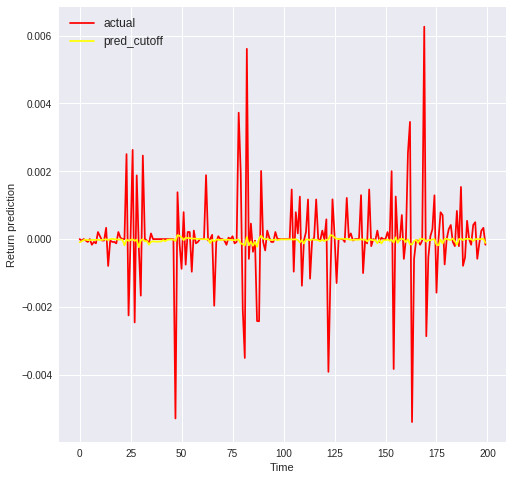

In [28]:
plt.figure(figsize=(8,8))
plt.plot(test.target[:200],color='red',label='actual')
plt.plot(pred[:200],color='yellow',label='pred_cutoff')
plt.xlabel("Time")
plt.ylabel('Return prediction')
plt.legend(loc="best", prop=dict(size=12))
plt.show()

In [29]:
def f(params):
    buy_limit = np.percentile(target, params['buy_limit']*100)
    sell_limit = np.percentile(target, params['sell_limit']*100)
    balance, profit, buy, sell = backtest(pred,list(test.price),buy_limit,sell_limit)
    val = max(profit)
    return {'loss': -val, 'status': STATUS_OK}

In [31]:
trials = Trials()
best = fmin(fn=f, space=space4st, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:', best)

best: {'buy_limit': 0, 'sell_limit': 5}


In [33]:
best_params = space_eval(space4st, best)
buy_limit = np.percentile(target, best_params['buy_limit']*100)
sell_limit = np.percentile(target, best_params['sell_limit']*100)
best_params = {'buy_limit':buy_limit, 'sell_limit':sell_limit}
pickle.dump(best_params, open('../saved_models/params_extratrees1.pkl','wb'))
print ("buy limit is return of " + str(buy_limit*100) + '%')
print ("sell limit is return of " + str(sell_limit*100) + '%')
balance, profit, buy, sell = backtest(pred,list(test.price),buy_limit,sell_limit)

buy limit is return of 0.0044031526573%
sell limit is return of -0.00435096635161%


/home/victor/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


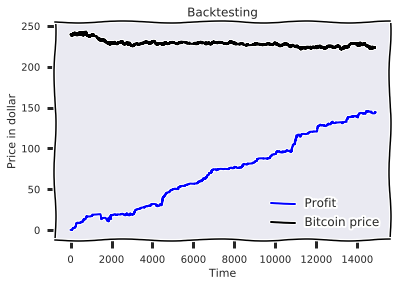

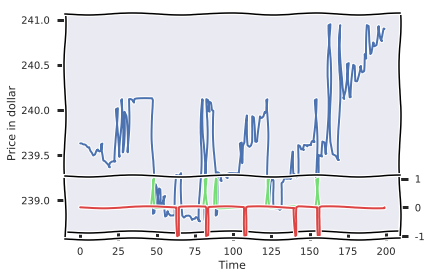

In [34]:
with plt.xkcd():
    plt.title('Backtesting')
    plt.plot(profit, color='blue', label="Profit")
    plt.plot(test.price, color = 'black', label = 'Bitcoin price')
    plt.xlabel("Time")
    plt.ylabel("Price in dollar")
    plt.legend(loc="best", prop=dict(size=12))
    plt.show()
    
with plt.xkcd():
    fig,ax1 = plt.subplots(1,1)
    ax1.plot(test.price[:200])
    plt.xlabel("Time")
    plt.ylabel("Price in dollar")
    ax2 = ax1.twinx()
    ax2.set_position(Bbox([[0.125,0.1],[0.9,0.32]]))
    ax2.plot(buy[:200], color='#77dd77')
    ax2.plot(sell[:200], color='#dd4444')
    plt.show()    

In [36]:
print ("Max profit at", test.time.iloc[profit.index(max(profit))], "with profit of USD ", max(profit), "and bitcoin price USD ",test.price.iloc[profit.index(max(profit))]) 
print ("Initial profit at", test.time.iloc[0], "with profit of USD ", profit[0], "and bitcoin price USD ",test.price.iloc[0])
print ("Final profit at", test.time.iloc[-1], "with profit of USD ", profit[-1], "and bitcoin price USD ",test.price.iloc[-1]) 

Max profit at 2015-02-04 19:11:16 with profit of USD  146.14 and bitcoin price USD  224.11
Initial profit at 2015-02-03 23:13:42 with profit of USD  0 and bitcoin price USD  239.63
Final profit at 2015-02-04 19:51:59 with profit of USD  144.64 and bitcoin price USD  223.88


we see that extratrees model profit is much lesser than regression model's. 